# ZMQ场景通信模式理解与练习

ZMQ是ZeroMQ的缩写，全称为Zero Message Queue。是一个高性能、可扩展的 消息 传递 库，用于构建分布式和并发 应用程序。在推理框架中，ZMQ是一款常用的通信库，使用例举：

- client与server通信；
- LLM模块与engine core的通信；
- DP并行时，不同DP之间的数据通信。


Author: kaiyuan

Email: kyxie@zju.edu.cn


ZMQ 相关资料：
* ZeroMQ官方指南：http://zguide.zeromq.org/

* ZeroMQ API文档：http://api.zeromq.org/

* 示例代码库：https://github.com/booksbyus/zguide

常见的ZMQ通信模式：

| 模式          | 拓扑结构 | 通信方式 | 方向性          | 主要用途            | 复杂度 |
| :------------ | :------- | :------- | :-------------- | :------------------ | :----- |
| REQ/REP       | 1-to-1   | 同步     | 双向            | RPC, 客户端-服务器  | 低     |
| PUB/SUB       | 1-to-N   | 异步     | 单向(PUB→SUB)   | 广播, 通知系统      | 中     |
| PUSH/PULL     | Pipeline | 异步     | 单向(PUSH→PULL) | 任务分发, 负载均衡  | 中     |
| ROUTER/DEALER | N-to-M   | 异步     | 双向            | 异步RPC, 代理服务   | 高     |
| POLLIN        | Any      | 异步     | 任何            | 多路复用, 非阻塞I/O | 中     |



## 1 REQ/REP (Request-Reply) 模式

特点

* 同步通信：严格的请求-响应顺序
* 一对一拓扑：每个请求对应一个响应
* 阻塞操作：客户端发送请求后阻塞等待响应
* 简单可靠：最基础的RPC模式

适用场景
* 远程过程调用（RPC）
* 客户端-服务器查询
* 需要严格顺序的对话

In [ ]:
# ==================== 导入必要的库 ====================
import zmq
import threading
import time
import random
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import matplotlib.patheffects as patheffects

# 设置图表样式
plt.style.use('seaborn-v0_8-darkgrid')

演示 1: REQ/REP (请求-响应) 模式
特点: 同步、一对一、严格的一问一答模式
REP Server started on port: 5555
REQ Client connected to port: 5555
Client sending: Calculate 1+1
Server received: Calculate 1+1
Client received: Response_1: Processed 'Calculate 1+1'
Client sending: Get time
Server received: Get time
Client received: Response_2: Processed 'Get time'
Client sending: Get status
Server received: Get status
Client received: Response_3: Processed 'Get status'


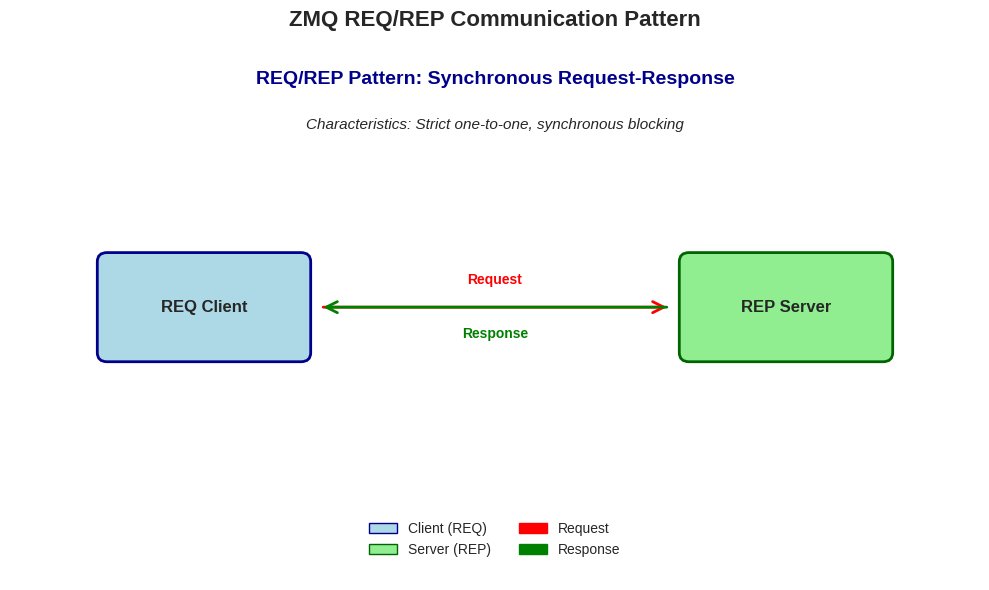

In [ ]:
class ReqRepPattern:
    """Request-Reply Pattern: Synchronous one-to-one communication"""

    @staticmethod
    def rep_server(port=5555, num_requests=5):
        """REP Server (Reply)"""
        context = zmq.Context()
        socket = context.socket(zmq.REP)
        socket.bind(f"tcp://*:{port}")

        print(f"REP Server started on port: {port}")
        responses = []

        for i in range(num_requests):
            message = socket.recv_string()
            print(f"Server received: {message}")

            response = f"Response_{i+1}: Processed '{message}'"
            time.sleep(0.5)  # Simulate processing time

            socket.send_string(response)
            responses.append((message, response))

        socket.close()
        context.term()
        return responses

    @staticmethod
    def req_client(port=5555, requests=None):
        """REQ Client (Request)"""
        if requests is None:
            requests = [f"Request_{i+1}" for i in range(5)]

        context = zmq.Context()
        socket = context.socket(zmq.REQ)
        socket.connect(f"tcp://localhost:{port}")

        print(f"REQ Client connected to port: {port}")
        results = []

        for i, request in enumerate(requests):
            print(f"Client sending: {request}")
            socket.send_string(request)

            response = socket.recv_string()
            print(f"Client received: {response}")
            results.append((request, response))

        socket.close()
        context.term()
        return results

    @staticmethod
    def run_demo():
        """运行演示"""
        port = 5555

        server_thread = threading.Thread(target=ReqRepPattern.rep_server, args=(port, 3))
        server_thread.daemon = True
        server_thread.start()

        time.sleep(1)  # 让server先起来

        client_results = ReqRepPattern.req_client(port, ["Calculate 1+1", "Get time", "Get status"])

        return client_results

    @staticmethod
    def plot_diagram():
        """绘制REQ/REP模式示意图"""
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.set_xlim(0, 10)
        ax.set_ylim(0, 6)
        ax.axis('off')

        client_box = patches.FancyBboxPatch((1, 2.5), 2, 1, boxstyle="round,pad=0.1",
                                           facecolor='lightblue', edgecolor='darkblue', linewidth=2)
        server_box = patches.FancyBboxPatch((7, 2.5), 2, 1, boxstyle="round,pad=0.1",
                                           facecolor='lightgreen', edgecolor='darkgreen', linewidth=2)

        ax.add_patch(client_box)
        ax.add_patch(server_box)

        ax.text(2, 3, "REQ Client", ha='center', va='center', fontsize=12, fontweight='bold')
        ax.text(8, 3, "REP Server", ha='center', va='center', fontsize=12, fontweight='bold')

        arrow_request = FancyArrowPatch((3.2, 3), (6.8, 3),
                                       arrowstyle='->', linewidth=2, color='red',
                                       connectionstyle="arc3,rad=0", mutation_scale=20)
        arrow_response = FancyArrowPatch((6.8, 3), (3.2, 3),
                                        arrowstyle='->', linewidth=2, color='green',
                                        connectionstyle="arc3,rad=0", mutation_scale=20)

        ax.add_patch(arrow_request)
        ax.add_patch(arrow_response)

        ax.text(5, 3.3, "Request", ha='center', va='center', fontsize=10, color='red', fontweight='bold')
        ax.text(5, 2.7, "Response", ha='center', va='center', fontsize=10, color='green', fontweight='bold')

        ax.text(5, 5.5, "REQ/REP Pattern: Synchronous Request-Response",
                ha='center', va='center', fontsize=14, fontweight='bold', color='darkblue')
        ax.text(5, 5, "Characteristics: Strict one-to-one, synchronous blocking",
                ha='center', va='center', fontsize=11, style='italic')

        # 添加图例
        legend_elements = [
            patches.Patch(facecolor='lightblue', edgecolor='darkblue', label='Client (REQ)'),
            patches.Patch(facecolor='lightgreen', edgecolor='darkgreen', label='Server (REP)'),
            mpatches.Arrow(0, 0, 1, 0, color='red', label='Request'),
            mpatches.Arrow(0, 0, 1, 0, color='green', label='Response')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)

        plt.title("ZMQ REQ/REP Communication Pattern", fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig

# 运行演示
print("=" * 60)
print("演示 1: REQ/REP (请求-响应) 模式")
print("特点: 同步、一对一、严格的一问一答模式")
print("=" * 60)
req_rep_results = ReqRepPattern.run_demo()
time.sleep(1)

# 绘制示意图
fig1 = ReqRepPattern.plot_diagram()
plt.show()

## 2. PUB/SUB (Publish-Subscribe) 模式

特点

- **异步通信**：发布者无需等待订阅者
- **一对多拓扑**：一个发布者，多个订阅者
- **主题过滤**：订阅者可以只接收特定主题的消息
- **非持久化**：慢速订阅者可能丢失消息

适用场景

- 新闻推送系统
- 股票行情广播
- 实时通知系统
- 事件驱动架构


演示 2: PUB/SUB (发布-订阅) 模式
特点: 异步、一对多、基于主题的消息广播
PUB Publisher started on port: 5556
Publisher sent: [weather] WEATHER message 1: Data 4
Publisher sent: [weather] WEATHER message 2: Data 87
Subscriber1 subscribed to topic: 'news'
Publisher sent: [news] NEWS message 3: Data 43
Subscriber1 received: news NEWS message 3: Data 43
Subscriber2 subscribed to topic: 'weather'
Publisher sent: [news] NEWS message 4: Data 62
Subscriber3 subscribed to topic: 'ALL'
Subscriber1 received: news NEWS message 4: Data 62
Publisher sent: [news] NEWS message 5: Data 78
Subscriber3 received: news NEWS message 5: Data 78
Publisher sent: [news] NEWS message 6: Data 75
Publisher sent: [sports] SPORTS message 7: Data 2
Publisher sent: [news] NEWS message 8: Data 89


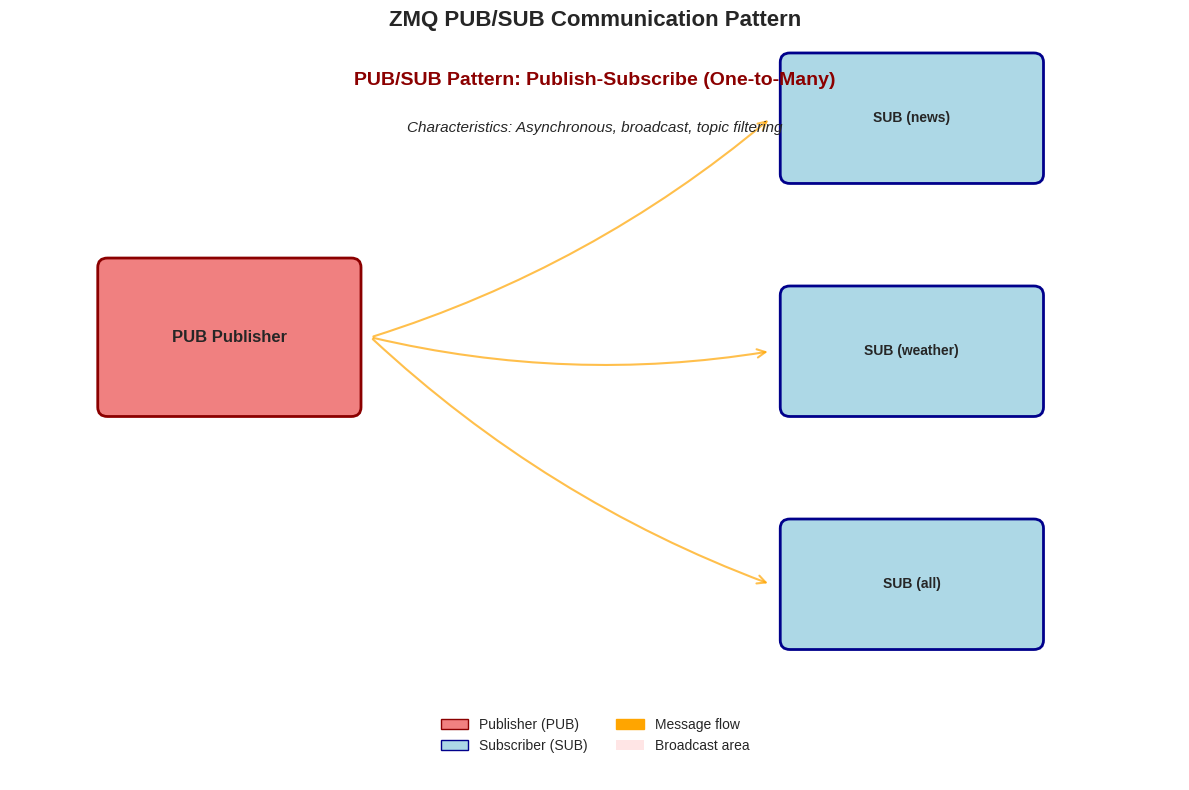

In [ ]:
class PubSubPattern:
    """Publish-Subscribe Pattern: Asynchronous one-to-many message distribution"""
    # 发布-订阅模式：异步一对多消息分发

    @staticmethod
    def publisher(port=5556, num_messages=10):
        """PUB Publisher"""
        # PUB 发布者
        context = zmq.Context()
        socket = context.socket(zmq.PUB)
        socket.bind(f"tcp://*:{port}")

        print(f"PUB Publisher started on port: {port}")
        time.sleep(1) # 给订阅者留出连接时间


        topics = ['news', 'weather', 'sports']
        messages_sent = []

        for i in range(num_messages):
            # 随机选择主题
            topic = random.choice(topics)
            message = f"{topic.upper()} message {i+1}: Data {random.randint(1, 100)}"

            # 发布消息 (格式: topic message)
            socket.send_string(f"{topic} {message}")
            print(f"Publisher sent: [{topic}] {message}")
            messages_sent.append((topic, message))

            time.sleep(0.3)

        socket.close()
        context.term()
        return messages_sent

    @staticmethod
    def subscriber(port=5556, topic_filter="", name="Subscriber"):
        """SUB Subscriber"""
        context = zmq.Context()
        socket = context.socket(zmq.SUB)
        socket.connect(f"tcp://localhost:{port}")

        # 设置 topic filter
        socket.setsockopt_string(zmq.SUBSCRIBE, topic_filter)

        print(f"{name} subscribed to topic: '{topic_filter if topic_filter else 'ALL'}'")
        messages_received = []
        # 接收 5 条消息
        for i in range(5):
            try:
                message = socket.recv_string(flags=zmq.NOBLOCK)
                print(f"{name} received: {message}")
                messages_received.append(message)
            except zmq.Again:
                pass
            time.sleep(0.1)

        socket.close()
        context.term()
        return messages_received

    @staticmethod
    def run_demo():
        """运行演示"""
        port = 5556

        # 启动发布者线程
        publisher_thread = threading.Thread(target=PubSubPattern.publisher, args=(port, 8))
        publisher_thread.daemon = True
        publisher_thread.start()

        time.sleep(1.5)


        # 启动多个订阅者线程
        subscribers = []
        threads = []

        # 创建 3 个具有不同 topic filter 的订阅者
        subscriber_configs = [
            ("news", "Subscriber1"),
            ("weather", "Subscriber2"),
            ("", "Subscriber3")

        ]

        for topic_filter, name in subscriber_configs:
            thread = threading.Thread(target=lambda tf=topic_filter, n=name: subscribers.append(
                PubSubPattern.subscriber(port, tf, n)
            ))
            thread.daemon = True
            thread.start()
            threads.append(thread)
            time.sleep(0.2)

        # 等待完成
        time.sleep(3)

        return subscribers

    @staticmethod
    def plot_diagram():
        """绘制PUB/SUB模式示意图"""
        fig, ax = plt.subplots(figsize=(12, 8))

        # 设置图表区域
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 8)
        ax.axis('off')

        # 绘制发布者
        pub_box = patches.FancyBboxPatch((1, 4), 2.5, 1.5, boxstyle="round,pad=0.1",
                                        facecolor='lightcoral', edgecolor='darkred', linewidth=2)
        ax.add_patch(pub_box)
        ax.text(2.25, 4.75, "PUB Publisher", ha='center', va='center', fontsize=12, fontweight='bold')

        # 绘制多个订阅者
        sub_positions = [(8, 6.5), (8, 4), (8, 1.5)]
        sub_labels = ["SUB (news)", "SUB (weather)", "SUB (all)"]

        for i, (x, y) in enumerate(sub_positions):
            sub_box = patches.FancyBboxPatch((x, y), 2.5, 1.2, boxstyle="round,pad=0.1",
                                           facecolor='lightblue', edgecolor='darkblue', linewidth=2)
            ax.add_patch(sub_box)
            ax.text(x+1.25, y+0.6, sub_labels[i], ha='center', va='center', fontsize=10, fontweight='bold')

            # 绘制从发布者到订阅者的消息流
            arrow = FancyArrowPatch((3.7, 4.75), (x-0.2, y+0.6),
                                  arrowstyle='->', linewidth=1.5, color='orange', alpha=0.7,
                                  connectionstyle="arc3,rad=0.1", mutation_scale=15)
            ax.add_patch(arrow)

        # 添加广播效果区域
        from matplotlib.patches import Wedge
        wedge = Wedge((3, 4.75), 6, 260, 280, width=0.5, alpha=0.1, color='red')
        ax.add_patch(wedge)

        # 添加模式标题
        ax.text(6, 7.5, "PUB/SUB Pattern: Publish-Subscribe (One-to-Many)",
                ha='center', va='center', fontsize=14, fontweight='bold', color='darkred')
        ax.text(6, 7, "Characteristics: Asynchronous, broadcast, topic filtering",
                ha='center', va='center', fontsize=11, style='italic')

        # 添加图例
        legend_elements = [
            patches.Patch(facecolor='lightcoral', edgecolor='darkred', label='Publisher (PUB)'),
            patches.Patch(facecolor='lightblue', edgecolor='darkblue', label='Subscriber (SUB)'),
            mpatches.Arrow(0, 0, 1, 0, color='orange', label='Message flow'),
            patches.Patch(facecolor='red', alpha=0.1, label='Broadcast area')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)

        plt.title("ZMQ PUB/SUB Communication Pattern", fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig

# 运行演示
print("\n" + "=" * 60)
print("演示 2: PUB/SUB (发布-订阅) 模式")
print("特点: 异步、一对多、基于主题的消息广播")
print("=" * 60)
pub_sub_results = PubSubPattern.run_demo()
time.sleep(1)

# 绘制示意图
fig2 = PubSubPattern.plot_diagram()
plt.show()

## 3. PUSH/PULL (Pipeline) 模式

特点

- **异步通信**：生产者推送任务后继续工作
- **负载均衡**：任务在多个工作者间分配
- **单向流动**：数据从PUSH流向PULL
- **管道拓扑**：适合构建处理流水线

适用场景

- 任务分发系统
- 并行计算
- 日志收集
- 工作队列


演示 3: PUSH/PULL (推-拉) 模式
特点: 管道模式、负载均衡、单向任务流
PUSH Ventilator started on port: 5557
Worker 1 started
Worker 1 received start signal
Worker 1 received task: 0
Ventilator sent: {'id': 0, 'task': 'Task_1', 'complexity': 5, 'timestamp': '13:14:58'}
Ventilator sent: {'id': 1, 'task': 'Task_2', 'complexity': 2, 'timestamp': '13:14:58'}
Worker 2 started
Ventilator sent: {'id': 2, 'task': 'Task_3', 'complexity': 2, 'timestamp': '13:14:59'}
Worker 1 completed: {'worker': 1, 'task_id': 0, 'status': 'completed', 'processing_time': '0.50s'}
Worker 1 received task: 1
Worker 3 started
Ventilator sent: {'id': 3, 'task': 'Task_4', 'complexity': 5, 'timestamp': '13:14:59'}
Worker 2 received start signal
Worker 1 completed: {'worker': 1, 'task_id': 1, 'status': 'completed', 'processing_time': '0.20s'}
Worker 1 received task: 2
Ventilator sent: {'id': 4, 'task': 'Task_5', 'complexity': 5, 'timestamp': '13:14:59'}
Worker 3 received start signal
Worker 1 completed: {'worker': 1, 'task_id': 2, 'status': 'co

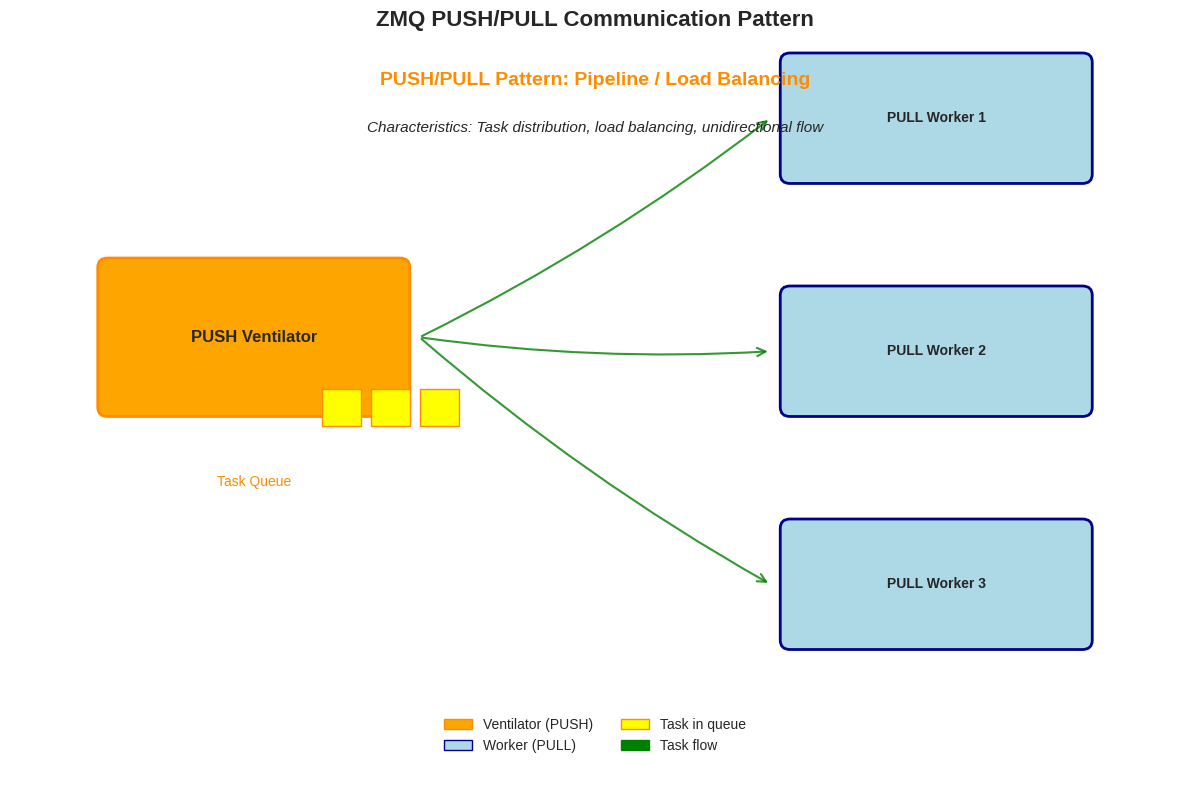

In [ ]:
class PushPullPattern:
    """Push-Pull Pattern: Pipeline for task distribution and result collection"""
    # 推-拉模式：用于任务分发和结果收集的管道

    @staticmethod
    def ventilator(port=5557, num_tasks=10):
        """PUSH Ventilator (Task distributor)"""
        # PUSH Ventilator（任务分发器）
        context = zmq.Context()
        socket = context.socket(zmq.PUSH)
        socket.bind(f"tcp://*:{port}")

        print(f"PUSH Ventilator started on port: {port}")
        time.sleep(1)     # 给 workers 留出连接时间


        tasks_sent = []

        # 发送启动信号
        socket.send_json({"type": "start_batch"})

        # 发送任务
        for i in range(num_tasks):
            task = {
                "id": i,
                "task": f"Task_{i+1}",
                "complexity": random.randint(1, 5),
                "timestamp": datetime.now().strftime("%H:%M:%S")
            }
            socket.send_json(task)
            print(f"Ventilator sent: {task}")
            tasks_sent.append(task)
            time.sleep(0.2)

        socket.close()
        context.term()
        return tasks_sent

    @staticmethod
    def worker(port=5557, worker_id=1):
        """PULL Worker"""
        # PULL Worker
        context = zmq.Context()
        socket = context.socket(zmq.PULL)
        socket.connect(f"tcp://localhost:{port}")

        print(f"Worker {worker_id} started")
        tasks_processed = []

        # 接收启动信号
        start_msg = socket.recv_json()
        print(f"Worker {worker_id} received start signal")

        for i in range(3):
            # 每个 worker 处理 3 个任务
            task = socket.recv_json()
            print(f"Worker {worker_id} received task: {task['id']}")

            # 模拟任务处理时间
            processing_time = task["complexity"] * 0.1
            time.sleep(processing_time)

            result = {
                "worker": worker_id,
                "task_id": task["id"],
                "status": "completed",
                "processing_time": f"{processing_time:.2f}s"
            }
            tasks_processed.append(result)
            print(f"Worker {worker_id} completed: {result}")

        socket.close()
        context.term()
        return result

    @staticmethod
    def run_demo():
        """运行演示"""
        port = 5557

        # 启动 ventilator 线程
        ventilator_thread = threading.Thread(target=PushPullPattern.ventilator, args=(port, 9))
        ventilator_thread.daemon = True
        ventilator_thread.start()

        time.sleep(1.5)

        # 启动多个 worker 线程
        workers = []
        threads = []

        for i in range(3):
            worker_id = i + 1
            thread = threading.Thread(target=lambda w=worker_id: workers.append(
                PushPullPattern.worker(port, w)
            ))
            thread.daemon = True
            thread.start()
            threads.append(thread)
            time.sleep(0.3)

        time.sleep(3)
        return workers

    @staticmethod
    def plot_diagram():
        """绘制PUSH/PULL模式示意图"""
        fig, ax = plt.subplots(figsize=(12, 8))

        # 设置图表区域
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 8)
        ax.axis('off')

        # 绘制任务分发器
        push_box = patches.FancyBboxPatch((1, 4), 3, 1.5, boxstyle="round,pad=0.1",
                                         facecolor='orange', edgecolor='darkorange', linewidth=2)
        ax.add_patch(push_box)
        ax.text(2.5, 4.75, "PUSH Ventilator", ha='center', va='center', fontsize=12, fontweight='bold')

        # 绘制任务队列
        queue_patches = []
        for i in range(3):
            task_box = patches.Rectangle((3.2 + i*0.5, 3.8), 0.4, 0.4,
                                       facecolor='yellow', edgecolor='darkorange', linewidth=1)
            ax.add_patch(task_box)
            queue_patches.append(task_box)

        # 绘制多个工作者
        worker_positions = [(8, 6.5), (8, 4), (8, 1.5)]

        for i, (x, y) in enumerate(worker_positions):
            pull_box = patches.FancyBboxPatch((x, y), 3, 1.2, boxstyle="round,pad=0.1",
                                            facecolor='lightblue', edgecolor='darkblue', linewidth=2)
            ax.add_patch(pull_box)
            ax.text(x+1.5, y+0.6, f"PULL Worker {i+1}", ha='center', va='center', fontsize=10, fontweight='bold')

            # 绘制从分发器到工作者的箭头
            arrow = FancyArrowPatch((4.2, 4.75), (x-0.2, y+0.6),
                                  arrowstyle='->', linewidth=1.5, color='green', alpha=0.8,
                                  connectionstyle="arc3,rad=0.05", mutation_scale=15)
            ax.add_patch(arrow)

        # 添加负载均衡说明
        ax.text(2.5, 3.2, "Task Queue", ha='center', va='center', fontsize=10, color='darkorange')

        # 添加模式标题
        ax.text(6, 7.5, "PUSH/PULL Pattern: Pipeline / Load Balancing",
                ha='center', va='center', fontsize=14, fontweight='bold', color='darkorange')
        ax.text(6, 7, "Characteristics: Task distribution, load balancing, unidirectional flow",
                ha='center', va='center', fontsize=11, style='italic')

        # 添加图例
        legend_elements = [
            patches.Patch(facecolor='orange', edgecolor='darkorange', label='Ventilator (PUSH)'),
            patches.Patch(facecolor='lightblue', edgecolor='darkblue', label='Worker (PULL)'),
            patches.Patch(facecolor='yellow', edgecolor='darkorange', label='Task in queue'),
            mpatches.Arrow(0, 0, 1, 0, color='green', label='Task flow')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)

        plt.title("ZMQ PUSH/PULL Communication Pattern", fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig


  # 运行演示
print("\n" + "=" * 60)
print("演示 3: PUSH/PULL (推-拉) 模式")
print("特点: 管道模式、负载均衡、单向任务流")
print("=" * 60)
push_pull_results = PushPullPattern.run_demo()
time.sleep(1)

# 绘制示意图
fig3 = PushPullPattern.plot_diagram()
plt.show()



## 4. ROUTER/DEALER (Asynchronous Request-Reply) 模式

特点

- **异步通信**：支持并发请求处理
- **多对多拓扑**：多个客户端与多个服务器通信
- **身份路由**：ROUTER知道每个消息的来源
- **灵活性强**：可以模拟其他所有模式

适用场景

- 异步RPC服务器
- 代理和负载均衡器
- 需要处理多个并发客户端的服务


演示 4: ROUTER/DEALER (路由-代理) 模式
特点: 异步、多客户端、基于身份的路由
ROUTER Server started on port: 6096
DEALER Client 1 started
Client 1 sent: Client1_Request1
DEALER Client 2 started
Client 2 sent: Client2_Request1
Server received from client: client_2
Client 1 received: 
DEALER Client 3 started
Client 3 sent: Client3_Request1
Server received from client: Client3_Request1
Client 1 sent: Client1_Request2
Client 1 received: Processed: client_2 at 13:15:05.014


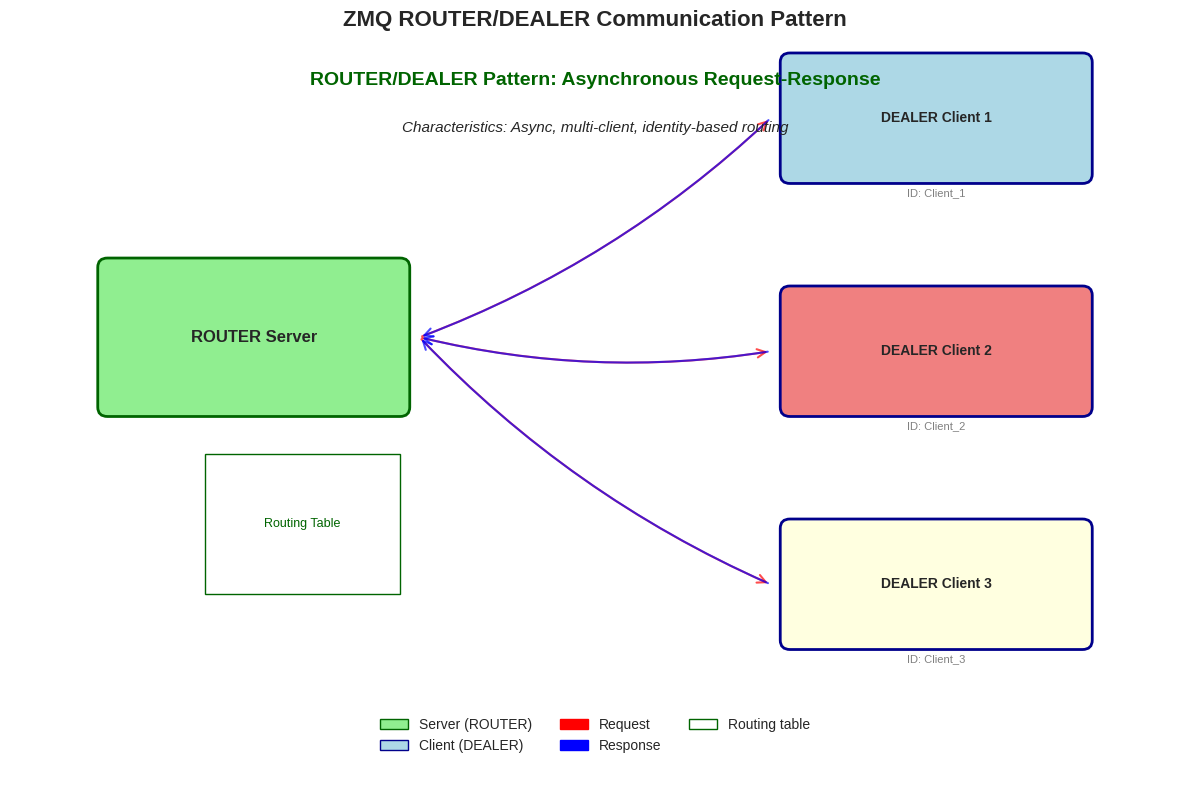

In [ ]:
class RouterDealerPattern:
    """Router-Dealer Pattern: Asynchronous request-reply with multiple clients"""
    # ROUTER-DEALER模式：支持多客户端的异步请求-响应

    @staticmethod
    def router_server(port=5558, num_clients=3):
        """ROUTER Server"""
        # ROUTER 服务器
        context = zmq.Context()
        socket = context.socket(zmq.ROUTER)
        socket.bind(f"tcp://*:{port}")

        print(f"ROUTER Server started on port: {port}")

        client_responses = {}
        poller = zmq.Poller()
        poller.register(socket, zmq.POLLIN)

        # 处理来自多个客户端的请求
        for _ in range(num_clients * 2):

            socks = dict(poller.poll(timeout=1000))

            if socket in socks:
                # ROUTER socket returns [identity, empty, message]
                identity = socket.recv()
                empty = socket.recv()  # Empty frame
                message = socket.recv_string()

                print(f"Server received from client: {message}")

                response = f"Processed: {message} at {datetime.now().strftime('%H:%M:%S.%f')[:-3]}"

                socket.send(identity, zmq.SNDMORE)
                socket.send(b"", zmq.SNDMORE)  # Empty frame
                socket.send_string(response)

                # 记录响应
                client_id = identity.hex()[:6]
                if client_id not in client_responses:
                    client_responses[client_id] = []
                client_responses[client_id].append((message, response))

        socket.close()
        context.term()
        return client_responses

    @staticmethod
    def dealer_client(port=5558, client_id=1, num_requests=2):
        """DEALER Client"""
        # DEALER 客户端
        context = zmq.Context()
        socket = context.socket(zmq.DEALER)

        # Set identity
        identity = f"client_{client_id}".encode()
        socket.setsockopt(zmq.IDENTITY, identity)

        socket.connect(f"tcp://localhost:{port}")

        print(f"DEALER Client {client_id} started")
        responses = []

        # 异步发送多个请求
        for i in range(num_requests):
            request = f"Client{client_id}_Request{i+1}"
            socket.send_string(request)
            print(f"Client {client_id} sent: {request}")

            # 接收响应
            response = socket.recv_string()
            print(f"Client {client_id} received: {response}")
            responses.append((request, response))

            time.sleep(0.3)

        socket.close()
        context.term()
        return responses

    @staticmethod
    def run_demo():
        """运行演示"""
        # Change port to avoid 'Address already in use' error
        port = random.randint(6000, 6100)

        server_thread = threading.Thread(target=RouterDealerPattern.router_server, args=(port, 3))
        server_thread.daemon = True
        server_thread.start()

        time.sleep(1)

        # 启动多个客户端线程
        clients = []
        threads = []

        for i in range(3):
            client_id = i + 1
            thread = threading.Thread(target=lambda cid=client_id: clients.append(
                RouterDealerPattern.dealer_client(port, cid, 2)
            ))
            thread.daemon = True
            thread.start()
            threads.append(thread)
            time.sleep(0.2)

        time.sleep(3)
        return clients

    @staticmethod
    def plot_diagram():
        """绘制ROUTER/DEALER模式示意图"""
        fig, ax = plt.subplots(figsize=(12, 8))

        # 设置图表区域
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 8)
        ax.axis('off')


        router_box = patches.FancyBboxPatch((1, 4), 3, 1.5, boxstyle="round,pad=0.1",
                                           facecolor='lightgreen', edgecolor='darkgreen', linewidth=2)
        ax.add_patch(router_box)
        ax.text(2.5, 4.75, "ROUTER Server", ha='center', va='center', fontsize=12, fontweight='bold')

        client_positions = [(8, 6.5), (8, 4), (8, 1.5)]
        client_colors = ['lightblue', 'lightcoral', 'lightyellow']

        for i, (x, y) in enumerate(client_positions):
            dealer_box = patches.FancyBboxPatch((x, y), 3, 1.2, boxstyle="round,pad=0.1",
                                              facecolor=client_colors[i], edgecolor='darkblue', linewidth=2)
            ax.add_patch(dealer_box)
            ax.text(x+1.5, y+0.6, f"DEALER Client {i+1}", ha='center', va='center', fontsize=10, fontweight='bold')


            arrow_request = FancyArrowPatch((4.2, 4.75), (x-0.2, y+0.6),
                                          arrowstyle='->', linewidth=1.5, color='red', alpha=0.7,
                                          connectionstyle="arc3,rad=0.1", mutation_scale=15)

            arrow_response = FancyArrowPatch((x-0.2, y+0.6), (4.2, 4.75),
                                           arrowstyle='->', linewidth=1.5, color='blue', alpha=0.7,
                                           connectionstyle="arc3,rad=-0.1", mutation_scale=15)

            ax.add_patch(arrow_request)
            ax.add_patch(arrow_response)


            ax.text(x+1.5, y-0.2, f"ID: Client_{i+1}", ha='center', va='center', fontsize=8, color='gray')


        routing_table = patches.Rectangle((2, 2), 2, 1.5, facecolor='white', edgecolor='darkgreen', linewidth=1)
        ax.add_patch(routing_table)
        ax.text(3, 2.75, "Routing Table", ha='center', va='center', fontsize=9, color='darkgreen')

        ax.text(6, 7.5, "ROUTER/DEALER Pattern: Asynchronous Request-Response",
                ha='center', va='center', fontsize=14, fontweight='bold', color='darkgreen')
        ax.text(6, 7, "Characteristics: Async, multi-client, identity-based routing",
                ha='center', va='center', fontsize=11, style='italic')

        legend_elements = [
            patches.Patch(facecolor='lightgreen', edgecolor='darkgreen', label='Server (ROUTER)'),
            patches.Patch(facecolor='lightblue', edgecolor='darkblue', label='Client (DEALER)'),
            mpatches.Arrow(0, 0, 1, 0, color='red', label='Request'),
            mpatches.Arrow(0, 0, 1, 0, color='blue', label='Response'),
            patches.Patch(facecolor='white', edgecolor='darkgreen', label='Routing table')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3)

        plt.title("ZMQ ROUTER/DEALER Communication Pattern", fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig

# 运行演示
print("\n" + "=" * 60)
print("演示 4: ROUTER/DEALER (路由-代理) 模式")
print("特点: 异步、多客户端、基于身份的路由")
print("=" * 60)
router_dealer_results = RouterDealerPattern.run_demo()
time.sleep(1)

# 绘制示意图
fig4 = RouterDealerPattern.plot_diagram()
plt.show()

## 5. POLLIN (Multiplexing) 模式

特点

- **非阻塞I/O**：避免线程阻塞等待
- **多路复用**：单个线程管理多个socket
- **事件驱动**：基于就绪事件处理
- **技术而非模式**：可以与其他模式结合使用

适用场景

- 需要同时处理多个连接的服务
- 避免创建过多线程
- 高性能服务器
- 实时数据处理

In [ ]:
import zmq
import time

def simple_pollin():

    print("超简单POLLIN示例")
    print("=" * 40)

    # 创建上下文
    ctx = zmq.Context()

    # 创建两个socket
    s1 = ctx.socket(zmq.REP)
    s2 = ctx.socket(zmq.REQ)

    # 绑定和连接
    s1.bind("tcp://*:7000")
    s2.connect("tcp://localhost:7000")

    # 创建poller
    poller = zmq.Poller()
    poller.register(s1, zmq.POLLIN)  # 监听s1的输入

    print("配置完成:")
    print("  s1: REP服务器 (端口7000)")
    print("  s2: REQ客户端")
    print("  poller监听s1")

    # 发送一个请求
    print("\n[客户端] 发送请求...")
    s2.send_string("Hello")

    # 轮询3次
    for i in range(3):
        print(f"\n轮询 {i+1}:")

        # 轮询，等待1秒
        socks = dict(poller.poll(1000))

        if s1 in socks:
            print("  s1有数据!")
            msg = s1.recv_string()
            print(f"  收到: {msg}")

            # 发送响应
            s1.send_string(f"World {i+1}")
            print(f"  发送响应: World {i+1}")

            # 客户端接收响应
            resp = s2.recv_string()
            print(f"  客户端收到响应: {resp}")
        else:
            print("  无事件")

    print("\n演示成功完成!")

    # 清理
    s1.close()
    s2.close()
    ctx.term()

# 运行超简单示例
if __name__ == "__main__":
    simple_pollin()

超简单POLLIN示例
配置完成:
  s1: REP服务器 (端口7000)
  s2: REQ客户端
  poller监听s1

[客户端] 发送请求...

轮询 1:
  s1有数据!
  收到: Hello
  发送响应: World 1
  客户端收到响应: World 1

轮询 2:
  无事件

轮询 3:
  无事件

演示成功完成!


## ZMQ的特点总结


ZMQ模式比较与总结


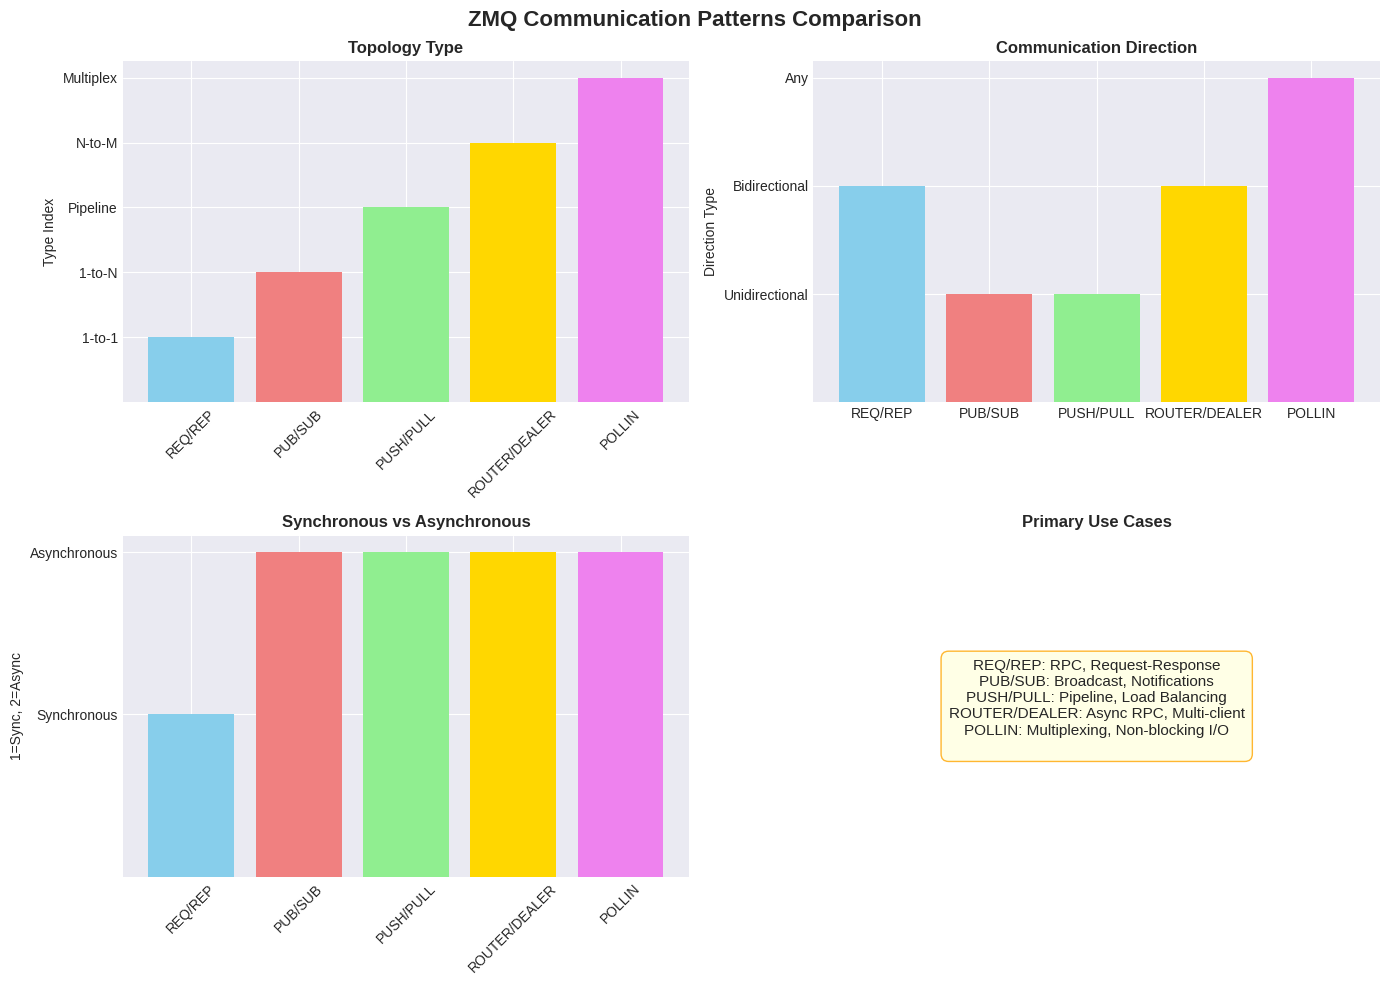


ZMQ通信模式总结

REQ/REP:
  套接字类型: REQ (Client), REP (Server)
  通信方式: Synchronous
  方向: Bidirectional
  拓扑结构: 1-to-1
  主要用途: RPC, Request-Response

PUB/SUB:
  套接字类型: PUB (Publisher), SUB (Subscriber)
  通信方式: Asynchronous
  方向: Unidirectional (PUB→SUB)
  拓扑结构: 1-to-N
  主要用途: Broadcast, Notifications

PUSH/PULL:
  套接字类型: PUSH (Sender), PULL (Receiver)
  通信方式: Asynchronous
  方向: Unidirectional (PUSH→PULL)
  拓扑结构: Pipeline
  主要用途: Pipeline, Load Balancing

ROUTER/DEALER:
  套接字类型: ROUTER (Server), DEALER (Client)
  通信方式: Asynchronous
  方向: Bidirectional
  拓扑结构: N-to-M
  主要用途: Async RPC, Multi-client

POLLIN:
  套接字类型: Any with Poller
  通信方式: Asynchronous
  方向: Any
  拓扑结构: Multiplexing
  主要用途: Multiplexing, Non-blocking I/O

关键要点:
1. REQ/REP: 最简单的RPC模式，严格同步的一对一通信
2. PUB/SUB: 发布-订阅模式，一对多的异步消息广播
3. PUSH/PULL: 管道模式，用于任务分发和结果收集
4. ROUTER/DEALER: 异步请求-响应，支持多客户端通信
5. POLLIN: 多路复用技术，用于管理多个socket的非阻塞I/O

选择建议:
- 需要简单RPC: 使用REQ/REP
- 需要消息广播: 使用PUB/SUB
- 需要任务分发: 使用PUSH/PULL
- 需要异步多客户端通信: 使用ROUTER/DEALER
- 需

In [ ]:
class ZMQPatternComparison:
    """ZMQ模式比较与总结"""

    @staticmethod
    def create_comparison_table():
        """创建ZMQ模式比较表 - 修正版"""
        patterns = [
            {
                "Pattern": "REQ/REP",
                "Socket Type": "REQ (Client), REP (Server)",
                "Communication": "Synchronous",
                "Direction": "Bidirectional",
                "Topology": "1-to-1",
                "Use Case": "RPC, Request-Response"
            },
            {
                "Pattern": "PUB/SUB",
                "Socket Type": "PUB (Publisher), SUB (Subscriber)",
                "Communication": "Asynchronous",
                "Direction": "Unidirectional (PUB→SUB)",
                "Topology": "1-to-N",
                "Use Case": "Broadcast, Notifications"
            },
            {
                "Pattern": "PUSH/PULL",
                "Socket Type": "PUSH (Sender), PULL (Receiver)",
                "Communication": "Asynchronous",
                "Direction": "Unidirectional (PUSH→PULL)",
                "Topology": "Pipeline",  # 修正这里，避免复杂的键名
                "Use Case": "Pipeline, Load Balancing"
            },
            {
                "Pattern": "ROUTER/DEALER",
                "Socket Type": "ROUTER (Server), DEALER (Client)",
                "Communication": "Asynchronous",
                "Direction": "Bidirectional",
                "Topology": "N-to-M",
                "Use Case": "Async RPC, Multi-client"
            },
            {
                "Pattern": "POLLIN",
                "Socket Type": "Any with Poller",
                "Communication": "Asynchronous",
                "Direction": "Any",
                "Topology": "Multiplexing",  # 修正这里
                "Use Case": "Multiplexing, Non-blocking I/O"
            }
        ]

        return patterns

    @staticmethod
    def plot_comparison_chart():
        """绘制模式比较图表"""
        patterns = ZMQPatternComparison.create_comparison_table()

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 提取数据用于图表
        pattern_names = [p["Pattern"] for p in patterns]

        # 1. 拓扑结构比较 - 使用简化后的映射
        topology_mapping = {
            "1-to-1": 1,
            "1-to-N": 2,
            "Pipeline": 3,  # PUSH/PULL作为管道
            "N-to-M": 4,
            "Multiplexing": 5  # POLLIN作为多路复用
        }
        topology_values = [topology_mapping[p["Topology"]] for p in patterns]

        colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet']
        axes[0, 0].bar(pattern_names, topology_values, color=colors)
        axes[0, 0].set_title("Topology Type", fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel("Type Index", fontsize=10)
        axes[0, 0].set_yticks([1, 2, 3, 4, 5])
        axes[0, 0].set_yticklabels(["1-to-1", "1-to-N", "Pipeline", "N-to-M", "Multiplex"])
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. 通信方向
        direction_mapping = {
            "Bidirectional": 2,
            "Unidirectional (PUB→SUB)": 1,
            "Unidirectional (PUSH→PULL)": 1,
            "Any": 3
        }
        direction_values = [direction_mapping[p["Direction"]] for p in patterns]

        axes[0, 1].bar(pattern_names, direction_values, color=colors)
        axes[0, 1].set_title("Communication Direction", fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel("Direction Type", fontsize=10)
        axes[0, 1].set_yticks([1, 2, 3])
        axes[0, 1].set_yticklabels(["Unidirectional", "Bidirectional", "Any"])
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 3. 同步/异步比较
        sync_async_mapping = {"Synchronous": 1, "Asynchronous": 2}
        sync_async_values = [sync_async_mapping[p["Communication"]] for p in patterns]

        axes[1, 0].bar(pattern_names, sync_async_values, color=colors)
        axes[1, 0].set_title("Synchronous vs Asynchronous", fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel("1=Sync, 2=Async", fontsize=10)
        axes[1, 0].set_yticks([1, 2])
        axes[1, 0].set_yticklabels(["Synchronous", "Asynchronous"])
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. 使用案例文本展示
        axes[1, 1].axis('off')
        use_cases_text = ""
        for i, pattern in enumerate(patterns):
            use_cases_text += f"{pattern['Pattern']}: {pattern['Use Case']}\n"

        axes[1, 1].text(0.5, 0.5, use_cases_text, ha='center', va='center', fontsize=11,
                       bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow",
                                edgecolor="orange", alpha=0.8))
        axes[1, 1].set_title("Primary Use Cases", fontsize=12, fontweight='bold')

        fig.suptitle("ZMQ Communication Patterns Comparison", fontsize=16, fontweight='bold')
        plt.tight_layout()

        return fig

    @staticmethod
    def print_summary():
        """打印总结"""
        print("\n" + "=" * 70)
        print("ZMQ通信模式总结")
        print("=" * 70)

        patterns = ZMQPatternComparison.create_comparison_table()

        for pattern in patterns:
            print(f"\n{pattern['Pattern']}:")
            print(f"  套接字类型: {pattern['Socket Type']}")
            print(f"  通信方式: {pattern['Communication']}")
            print(f"  方向: {pattern['Direction']}")
            print(f"  拓扑结构: {pattern['Topology']}")
            print(f"  主要用途: {pattern['Use Case']}")

        print("\n" + "=" * 70)
        print("关键要点:")
        print("1. REQ/REP: 最简单的RPC模式，严格同步的一对一通信")
        print("2. PUB/SUB: 发布-订阅模式，一对多的异步消息广播")
        print("3. PUSH/PULL: 管道模式，用于任务分发和结果收集")
        print("4. ROUTER/DEALER: 异步请求-响应，支持多客户端通信")
        print("5. POLLIN: 多路复用技术，用于管理多个socket的非阻塞I/O")
        print("\n选择建议:")
        print("- 需要简单RPC: 使用REQ/REP")
        print("- 需要消息广播: 使用PUB/SUB")
        print("- 需要任务分发: 使用PUSH/PULL")
        print("- 需要异步多客户端通信: 使用ROUTER/DEALER")
        print("- 需要同时处理多个socket: 使用POLLIN")
        print("=" * 70)

# 创建比较图表
print("\n" + "=" * 70)
print("ZMQ模式比较与总结")
print("=" * 70)
comparison_fig = ZMQPatternComparison.plot_comparison_chart()
plt.show()

# 打印总结
ZMQPatternComparison.print_summary()